In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import keras
import numpy as np

In [2]:
train_path = "Spectrgraph/train"
valid_path = "Spectrgraph/val"

In [3]:
image_size = (224, 224)
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [4]:
valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 366 images belonging to 5 classes.


In [6]:
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 91 images belonging to 5 classes.


In [22]:
num_classes = len(train_generator.class_indices)
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.85))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [23]:
from tensorflow.keras.optimizers import Adam

# Compile the model with Adam optimizer
model.compile(
    optimizer=Adam(lr=0.0001),  # You can adjust the learning rate as needed
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)

Epoch 1/5
12/12 [==============================] - 47s 4s/step - loss: 6.3000 - accuracy: 0.7131 - val_loss: 0.6737 - val_accuracy: 0.8352
Epoch 2/5
12/12 [==============================] - 44s 4s/step - loss: 0.8513 - accuracy: 0.8361 - val_loss: 0.6944 - val_accuracy: 0.8352
Epoch 3/5
12/12 [==============================] - 44s 4s/step - loss: 0.7697 - accuracy: 0.8361 - val_loss: 0.6752 - val_accuracy: 0.8352
Epoch 4/5
12/12 [==============================] - 68s 6s/step - loss: 0.7581 - accuracy: 0.8361 - val_loss: 0.7304 - val_accuracy: 0.8352
Epoch 5/5
12/12 [==============================] - 79s 6s/step - loss: 0.7415 - accuracy: 0.8361 - val_loss: 0.7071 - val_accuracy: 0.8352


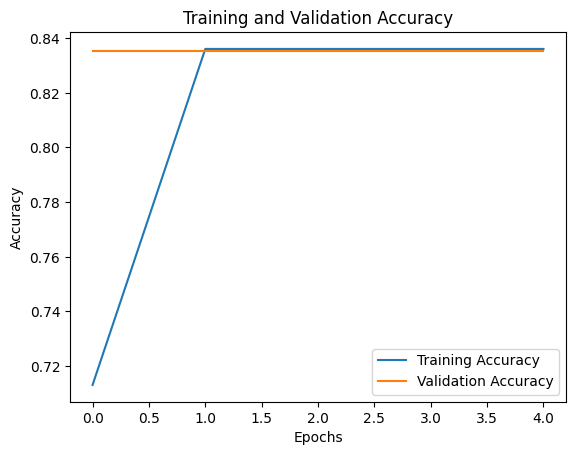

In [25]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

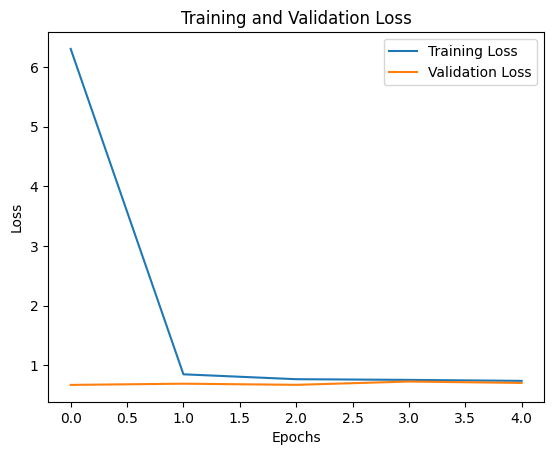

In [26]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [27]:
# Make predictions on test data
test_loss, test_accuracy = model.evaluate(valid_generator, steps=len(valid_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the trained model
model.save("trained_model_new_cnn.h5")
print("Trained model saved as 'trained_model_new_cnn.h5'")

3/3 [==============================] - 2s 491ms/step - loss: 0.7071 - accuracy: 0.8352
Test Loss: 0.7071
Test Accuracy: 0.8352
Trained model saved as 'trained_model_new_cnn.h5'


1/1 [==============================] - 0s 205ms/step


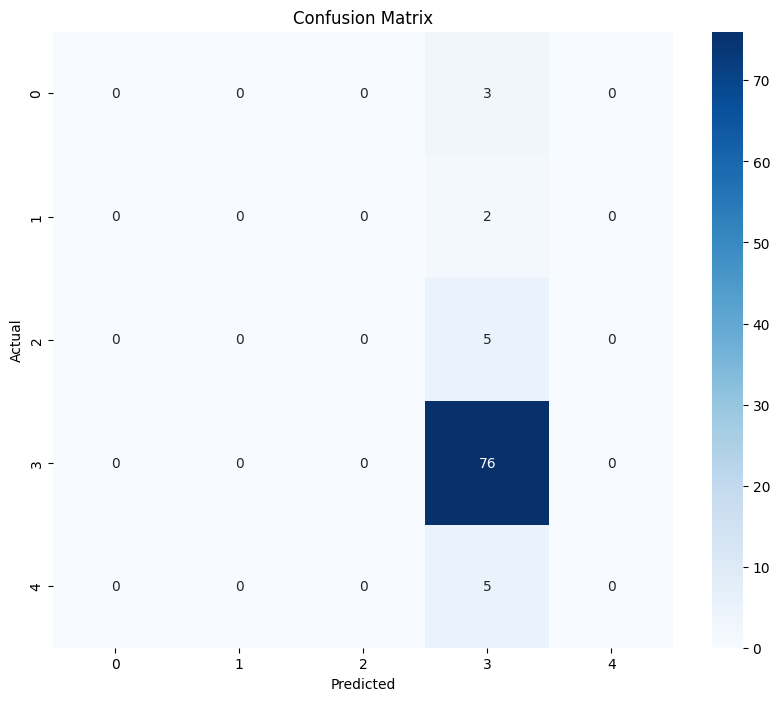

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
# Load the saved model
loaded_model = tf.keras.models.load_model("trained_model.h5")

# Initialize variables
num_samples = len(valid_generator.filenames)
batch_size = 32
num_batches = int(np.ceil(num_samples / batch_size))
all_test_labels = []
all_predicted_labels = []

# Generate predictions in batches
for _ in range(num_batches):
    batch_images, batch_labels = next(valid_generator)
    batch_predictions = loaded_model.predict(batch_images)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    
    all_test_labels.extend(np.argmax(batch_labels, axis=1))
    all_predicted_labels.extend(batch_predicted_labels)

# Generate confusion matrix
cm = confusion_matrix(all_test_labels, all_predicted_labels)

# Plot the confusion matrix
class_names = [str(i) for i in range(num_classes)]  # Replace with actual class names if available
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()